In [1]:
import os
import numpy as np
import pickle
from pathlib import Path
from typing import List, Tuple
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler


def load_features_and_filenames(features_dir, layer="raw_cornet-s_IT.conv3"):
    """
    Load features and file names from a given features_* folder.

    Args:
        features_dir (str): Path to features folder (e.g., features_animals)

    Returns:
        features (np.ndarray): Loaded features array
        file_names (List[str]): List of file names in correct order
    """
    features_dir = Path(features_dir)

    # Find the inner raw_* folder (e.g., raw_cornet-s_V1.conv2)
    raw_folders = [d for d in features_dir.iterdir() if d.is_dir() and d.name.startswith(layer)]
    if len(raw_folders) == 0:
        raise FileNotFoundError(f"No raw folder found in {features_dir}")
    if len(raw_folders) > 1:
        print(f"Warning: multiple raw folders found in {features_dir}, using the first one")

    raw_folder = raw_folders[0]

    # Load features.npy
    features_path = raw_folder / "features.npy"
    if not features_path.exists():
        raise FileNotFoundError(f"Features file not found: {features_path}")
    features = np.load(features_path)

    # Load file_names.txt
    file_names_path = features_dir / "file_names.txt"
    if not file_names_path.exists():
        raise FileNotFoundError(f"File names file not found: {file_names_path}")
    
    with open(file_names_path, "r") as f:
        file_names = [line.strip() for line in f.readlines()]

    # Optional check
    if features.shape[0] != len(file_names):
        print(f"Warning: number of features ({features.shape[0]}) != number of file names ({len(file_names)})")

    return features, file_names

def get_subcategories(file_paths, category_name):
    """
    Extract subcategories from file paths.
    
    Args:
        file_paths (list): contains full paths
        category_name (str): e.g., 'plants'
    
    Returns:
        subcategory_dict (dict): subcategory -> list of indices
    """
    subcategory_dict = {}
    for idx, fp in enumerate(file_paths):
        p = Path(fp)
        # folder right after Images_<category>
        # path example: .../Images_plants/aloe/aloe_01b.jpg
        try:
            images_idx = p.parts.index(f"Images_{category_name}")
            subcategory = p.parts[images_idx + 1]
        except ValueError:
            raise ValueError(f"Path {fp} does not contain Images_{category_name}")
        
        if subcategory not in subcategory_dict:
            subcategory_dict[subcategory] = []
        subcategory_dict[subcategory].append(idx)
    
    return subcategory_dict

def average_features_by_subcategory(features, file_paths, category_name):
    """
    Average features per subcategory and return as an array.

    Args:
        features (np.ndarray):  of shape (num_images, num_features)
        file_paths (list): contains file paths corresponding to features
        category_name: e.g., 'plants'

    Returns:
        avg_features_array (np.ndarray):  of shape (num_subcategories, num_features)
        subcategories (list): contains subcategory names in order corresponding to avg_features_array
    """
    # Step 1: get subcategory indices
    subcategory_dict = {}
    for idx, fp in enumerate(file_paths):
        p = Path(fp)
        images_idx = p.parts.index(f"Images_{category_name}")
        subcat = p.parts[images_idx + 1]
        subcategory_dict.setdefault(subcat, []).append(idx)

    # Step 2: sort subcategories alphabetically (optional)
    subcategories = sorted(subcategory_dict.keys())

    # Step 3: compute mean features for each subcategory and stack into array
    avg_features_array = np.stack([features[subcategory_dict[subcat]].mean(axis=0) for subcat in subcategories], axis=0)

    return avg_features_array, subcategories


def load_data(file):
    """
    Load data from a pickle file.
    ------
    Args:
        file (str): The path to the pickle file to be loaded.

    Returns:
        data: The data loaded from the pickle file.
    """
    with open(file, 'rb') as f:
        data = pickle.load(f)
    return data

def extract_similarity(catA, catB, cat_names, rdm, min_thres=0, max_thres=0.6):
    """
    Get similairity scores between two big categories (e.g. animals and objects).
    ------
    Args:
        catA, catB (np.ndarray): contains indexes corresponding to catA/B
        cat_names (list): contains 
        rdm (np.ndarray): the upper triangle of a square rdm 
        min_thres, max_thres (scalar): similarity thersholds 

    Returns:
        similar_ (list): List of similar pairs with their corresponding sim score.
    """
    mask = (upper_triangle_matrix > min_thres) & (upper_triangle_matrix < max_thres)
    x, y = np.where(mask)
    coordinates = np.array([x, y])
    similar_ = []
    for coord in range(coordinates.shape[1]):
        x1 = coordinates[0, coord]
        y1 = coordinates[1, coord]
        if x1 in catA:
            if y1 in catB:
                similar_.append((cat_names[x1], cat_names[y1], rdm[x1, y1]))
    return similar_



In [2]:
categories = ["animals", "objects"]
base_dir = "/projects/archiv/DataStore_Boyanova/ExpAtt_EEG/Image_dataset"
V1_fts = []
IT_fts = []
all_file_names = []
gloabal_categories = []
animal_type = np.array(load_data("./Animacy/categories.pkl")["animal_type"])

sub_categories = {}
for cat_idx, cat in enumerate(categories):
    print(cat)
    features_dir = os.path.join(base_dir, f"features_{cat}")
    features_IT, file_names = load_features_and_filenames(features_dir)   
    features_V1, file_names = load_features_and_filenames(features_dir, layer="raw_cornet-s_V1.conv1")   
    subcats = get_subcategories(file_names, category_name=cat)
    gloabal_categories.extend([cat] * len(file_names))
    
    if cat_idx > 0:
        number = len(all_file_names)
        for k in subcats:
            subcats[k] = [x + number for x in subcats[k]]
          
    sub_categories.update(subcats)
    V1_fts.extend(features_V1)
    IT_fts.extend(features_IT)
    all_file_names.extend(file_names)

print("Stacking...")
V1_fts = np.stack(V1_fts)
IT_fts = np.stack(IT_fts)
gloabal_categories= np.array(gloabal_categories)
all_file_names = np.array(all_file_names)


animals
objects
Stacking...


In [3]:
# Creating categorical features to find most similar categories rather than individual images 
categorical_features = []
category_names = []
global_category_names = []
for k, v in sub_categories.items():
    category_names.append(k)
    categorical_features.append(IT_fts[v, :].mean(axis=0))
    glob_cat = np.unique(gloabal_categories[v])[0]
    if glob_cat == "animals":
        global_category_names.append(animal_type[np.where(np.array(category_names) == k)][0])
    else:
        global_category_names.append(glob_cat)

categorical_features = np.stack(categorical_features)
global_category_names = np.array(global_category_names, dtype=str)


In [4]:
# Normalize
category_features = StandardScaler().fit_transform(categorical_features)

mammals = np.where(global_category_names == "mammal")[0]
insects = np.where(global_category_names == "insect")[0]
birds = np.where(global_category_names == "bird")[0]
objects = np.where(global_category_names == "objects")[0]


In [5]:
rdm_ = squareform(pdist(category_features, metric="correlation"))
upper_triangle_matrix = np.triu(rdm_, k=1)


In [6]:
similar_mammals = extract_similarity(mammals, mammals, cat_names=category_names, rdm=upper_triangle_matrix)
similar_insects = extract_similarity(insects, insects, cat_names=category_names, rdm=upper_triangle_matrix, max_thres=0.7)
similar_objects = extract_similarity(objects, objects, cat_names=category_names, rdm=upper_triangle_matrix, max_thres=0.7)
similar_birds = extract_similarity(birds, birds, cat_names=category_names, rdm=upper_triangle_matrix, max_thres=0.7)


similar_mammals_objects = extract_similarity(mammals, objects, cat_names=category_names, rdm=upper_triangle_matrix, min_thres=0, max_thres=0.9)
similar_birds_objects = extract_similarity(birds, objects, cat_names=category_names, rdm=upper_triangle_matrix, min_thres=0, max_thres= 1.9)
similar_insects_objects = extract_similarity(insects, objects, cat_names=category_names, rdm=upper_triangle_matrix, min_thres=0, max_thres=0.9)


In [7]:
sorted(similar_mammals, key=lambda x: x[2])


[('gopher', 'groundhog', 0.25557833050274714),
 ('cheetah', 'leopard', 0.3083929667866919),
 ('coyote', 'wolf', 0.3476118269972145),
 ('chipmunk', 'squirrel', 0.35138851165720864),
 ('hamster', 'mouse1', 0.35633716914331626),
 ('hedgehog', 'porcupine', 0.37587034068566283),
 ('cat', 'kitten', 0.37850395750246835),
 ('ferret', 'weasel', 0.3969489313661333),
 ('chipmunk', 'gopher', 0.40622489398562955),
 ('mouse1', 'rat', 0.41784173060427343),
 ('deer', 'kangaroo', 0.42114237573206403),
 ('beaver', 'gopher', 0.4247555262319215),
 ('bull', 'yak', 0.4279220133021685),
 ('guinea_pig', 'hamster', 0.43642318741922037),
 ('deer', 'reindeer', 0.44522207611976683),
 ('antelope', 'gazelle', 0.44578160009934475),
 ('coyote', 'fox', 0.44772848773794804),
 ('meerkat', 'mongoose', 0.452658099550164),
 ('chipmunk', 'mouse1', 0.45532743569530665),
 ('beaver', 'groundhog', 0.45560267991022185),
 ('deer', 'gazelle', 0.45619857251663354),
 ('hippopotamus', 'rhinoceros', 0.4584840833042447),
 ('antelope', 

In [8]:
### Selecting categories and picking images for masking 
selection1 = ["dolphin", "whale", "speedboat", "submarine"]
selection2 = ["eagle", "hawk", "jet", "helicopter"]
np.random.seed(2025)
indexes_sel1 = []
category_len1 = []
for k in selection1:
    category_len1.append(len(sub_categories[k]))
    indexes_sel1.extend(sub_categories[k])
    
indexes_sel2 = []
for k in selection2:
    indexes_sel2.extend(sub_categories[k])
    
indexes_out = np.array(indexes_sel1 + indexes_sel2)
out_mask = np.isin(np.arange(len(gloabal_categories)), indexes_out)
masked_global_categories = gloabal_categories[~out_mask]
masked_file_names = all_file_names[~out_mask]

image_paths_masking = []

for cat in categories:
    cat_mask = np.isin(masked_global_categories, cat)
    image_paths_masking.extend(np.random.choice(masked_file_names[cat_mask], 6, replace=False))

image_paths_masking = np.array(image_paths_masking)
#np.save("./Animacy/masking_paths.npy", image_paths_masking)

In [9]:
### need a lot of time + RAM
#image_features_V1 = StandardScaler().fit_transform(V1_fts)
image_features_IT = StandardScaler().fit_transform(IT_fts) 

In [10]:
rdm_1 = squareform(pdist(image_features_IT[indexes_sel1], metric="correlation"))
rdm_2 = squareform(pdist(image_features_IT[indexes_sel2], metric="correlation"))

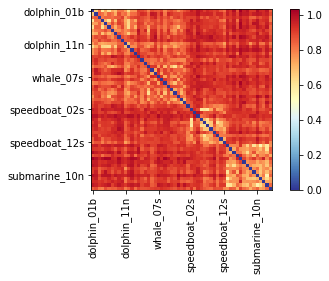

In [11]:
import matplotlib.pyplot as plt

labels = [x.split("/")[-1].split(".")[0] for x in all_file_names[indexes_sel1]]
fig, ax = plt.subplots()
im = ax.imshow(rdm_1, cmap="RdYlBu_r")
plt.colorbar(im)

# Get current tick positions
xticks = ax.get_xticks().astype(int)
yticks = ax.get_yticks().astype(int)

# Keep only ticks that are valid indices
xticks = [i for i in xticks if 0 <= i < len(labels)]
yticks = [i for i in yticks if 0 <= i < len(labels)]

# Set ticks and corresponding labels
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xticklabels([labels[i] for i in xticks], rotation=90)
ax.set_yticklabels([labels[i] for i in yticks])

plt.tight_layout()
plt.show()


In [12]:
from PIL import Image
def plot_images_side_by_side(path1, path2, titles=None):
    """
    Display two images side by side.

    Parameters
    ----------
    path1 (str): Path to first image.
    path2 : Path to second image.
    titles : list[str] | None
        Optional list of two titles.
    """
    img1 = Image.open(path1)
    img2 = Image.open(path2)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(img1)
    axes[0].axis("off")
    if titles and len(titles) > 0:
        axes[0].set_title(titles[0])

    axes[1].imshow(img2)
    axes[1].axis("off")
    if titles and len(titles) > 1:
        axes[1].set_title(titles[1])

    plt.tight_layout()
    plt.show()

In [ ]:
np.where((upper_triangle_matrix > 0.2) & (upper_triangle_matrix < 0.65))[0].shape

In [13]:
rdm_ = squareform(pdist(image_features_IT, metric="correlation"))
upper_triangle_matrix = np.triu(rdm_, k=1)

indexes = np.random.choice(200, 10)
B = np.where((upper_triangle_matrix > 0.2) & (upper_triangle_matrix < 0.65))[0][indexes]
A = np.where((upper_triangle_matrix > 0.2) & (upper_triangle_matrix < 0.65))[1][indexes]

for a,b in zip(A,B):
    plot_images_side_by_side(
        all_file_names[a],
        all_file_names[b],
        titles=["Image A", "Image B"]
    )
